In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
# from tqdm.notebook import tqdm
from tqdm import tqdm_notebook as tqdm

In [5]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. You should probably not do this.


In [6]:
class dataset:
    def __init__(self,data,target):
        self.data = data
        self.target = target
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = self.data[idx]
        y = self.target[idx]
        
        return X,y

In [ ]:
data = np.load("armdata.npy")
data = data.reshape(100,100,3)

In [5]:
# temp = [0]*10+[1]*10+[2]*10+[3]*10+[4]*10+[5]*10+[6]*10+[7]*10+[8]*10+[9]*10
# temp = np.array(temp)

# target = np.zeros((100,10))
# for i in range(100):
#     target[i,temp[i]] = 1

In [6]:
target = [0]*10+[1]*10+[2]*10+[3]*10+[4]*10+[5]*10+[6]*10+[7]*10+[8]*10+[9]*10
target = np.array(target)

In [7]:
data = torch.from_numpy(data).float()
target = torch.from_numpy(target).long()

In [8]:
test_idx = np.arange(10)*10
train_idx = np.delete(np.arange(100),test_idx)

data_test = data[test_idx]
data_train = data[train_idx]
target_test = target[test_idx]
target_train = target[train_idx]

trainset = dataset(data_train,target_train)
testset = dataset(data_test,target_test)

In [9]:
batch_size=10

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [7]:
# #We define the training as a function so we can easily re-use it.
# def train(model, optimizer, num_epochs=10):
#     train_acc_all = []
#     test_acc_all = []

#     for epoch in tqdm(range(num_epochs), unit='epoch'):
#         model.train()
#         #For each epoch
#         train_correct = 0
#         for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
#             data, target = data.to(device), target.to(device)
#             #Zero the gradients computed for each weight
#             optimizer.zero_grad()
#             #Forward pass your image through the network
#             output = model(data)
#             #Compute the loss
#             loss = F.nll_loss(torch.log(output), target)
#             #Backward pass through the network
#             loss.backward()
#             #Update the weights
#             optimizer.step()

#             #Compute how many were correctly classified
#             predicted = output.argmax(1)
#             train_correct += (target==predicted).sum().cpu().item()
#         #Comput the test accuracy
#         test_correct = 0
#         model.eval()
#         for data, target in test_loader:
#             data = data.to(device)
#             with torch.no_grad():
#                 output = model(data)
#             predicted = output.argmax(1).cpu()
#             test_correct += (target==predicted).sum().item()
#         train_acc = train_correct/len(trainset)
#         test_acc = test_correct/len(testset)
#         train_acc_all.append(train_acc)
#         test_acc_all.append(test_acc)
#         print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
#     return test_acc_all, train_acc_all

In [54]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    train_acc_all = []
    test_acc_all = []

    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        for minibatch_no, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = F.nll_loss(torch.log(output), target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data = data.to(device)
            with torch.no_grad():
                output = model(data)
            predicted = output.argmax(1).cpu()
            test_correct += (target==predicted).sum().item()
        train_acc = train_correct/len(trainset)
        test_acc = test_correct/len(testset)
        train_acc_all.append(train_acc)
        test_acc_all.append(test_acc)
        print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
    return test_acc_all, train_acc_all

In [51]:
class LinearNet(nn.Module):
    def __init__(self,p):
        super(LinearNet, self).__init__()
        
        self.linear = nn.Sequential(nn.Linear(in_features=300,out_features=150),
                                    nn.ReLU(),
                                    nn.Dropout(p=p),
                                    nn.Linear(150,75),
                                    nn.ReLU(),
                                    nn.Dropout(p=p),
                                    nn.Linear(75,10),
                                    nn.Softmax(dim=1))
                                      

        
    def forward(self, x): #x = [batch_size,100,3]
        x = x.view(x.shape[0],-1)
        x = self.linear(x)
        return x


In [55]:
model = LinearNet(p=0.15)
model.to(device)
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

In [56]:
test_acc, train_acc = train(model, optimizer,num_epochs=10)

Accuracy train: 12.1%	 test: 0.0%
Accuracy train: 15.2%	 test: 0.0%
Accuracy train: 11.1%	 test: 100.0%
Accuracy train: 10.1%	 test: 0.0%
Accuracy train: 23.2%	 test: 100.0%
Accuracy train: 7.1%	 test: 100.0%
Accuracy train: 13.1%	 test: 0.0%
Accuracy train: 13.1%	 test: 0.0%
Accuracy train: 13.1%	 test: 0.0%
Accuracy train: 10.1%	 test: 0.0%


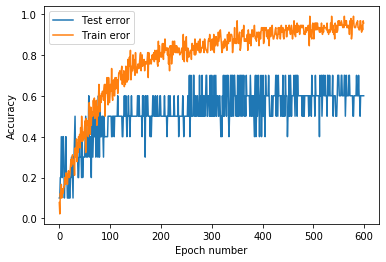

In [42]:
plt.plot(test_acc)
plt.plot(train_acc)
plt.legend(('Test error','Train eror'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
# plt.savefig("TrainingAccuracy")
plt.show()

In [41]:
# torch.save(model.state_dict(),"linearClassifier")

In [32]:
# data = np.load("armdata.npy")
# data = data.reshape(100,100,3)
# target = [0]*10+[1]*10+[2]*10+[3]*10+[4]*10+[5]*10+[6]*10+[7]*10+[8]*10+[9]*10
# target = np.array(target)
# data = torch.from_numpy(data).float()
# target = torch.from_numpy(target).long()

# test_acc_all = []
# train_acc_all = []

# batch_size=10

# for i in tqdm(range(100),unit="model"):
#     test_idx = torch.tensor([i])
#     train_idx = np.delete(np.arange(100),test_idx)
#     data_test = data[test_idx]
#     data_train = data[train_idx]
#     target_test = target[test_idx]
#     target_train = target[train_idx]

#     trainset = dataset(data_train,target_train)
#     testset = dataset(data_test,target_test)

#     train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
#     test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)
    
#     model = LinearNet(p=0.15)
#     model.to(device)
#     lr = 1e-4
#     optimizer = optim.Adam(model.parameters(), lr=lr)
#     test_acc, train_acc = train(model, optimizer,num_epochs=600)
#     test_acc_all.append(test_acc)
#     train_acc_all.append(train_acc)

Accuracy train: 8.1%	 test: 0.0%


Accuracy train: 11.1%	 test: 0.0%


Accuracy train: 8.1%	 test: 0.0%


Accuracy train: 9.1%	 test: 0.0%


Accuracy train: 12.1%	 test: 0.0%


Accuracy train: 8.1%	 test: 0.0%


Accuracy train: 16.2%	 test: 100.0%


Accuracy train: 17.2%	 test: 100.0%


Accuracy train: 17.2%	 test: 100.0%


Accuracy train: 17.2%	 test: 100.0%


Accuracy train: 10.1%	 test: 0.0%


Accuracy train: 17.2%	 test: 100.0%


Accuracy train: 11.1%	 test: 100.0%


Accuracy train: 17.2%	 test: 100.0%


Accuracy train: 17.2%	 test: 100.0%


Accuracy train: 25.3%	 test: 0.0%


Accuracy train: 18.2%	 test: 0.0%


Accuracy train: 23.2%	 test: 0.0%


Accuracy train: 27.3%	 test: 100.0%


Accuracy train: 23.2%	 test: 0.0%


Accuracy train: 25.3%	 test: 0.0%


Accuracy train: 13.1%	 test: 100.0%


Accuracy train: 18.2%	 test: 100.0%


Accuracy train: 31.3%	 test: 100.0%


Accuracy train: 25.3%	 test: 100.0%


Accuracy train: 26.3%	 test: 100.0%


Accuracy train: 27.3%	 test: 100.0%


Accuracy train: 28.3%	 test: 100.0%


Accuracy train: 36.4%	 test: 0.0%


Accuracy train: 27.3%	 test: 100.0%


Accuracy train: 27.3%	 test: 100.0%


Accuracy train: 28.3%	 test: 100.0%


Accuracy train: 29.3%	 test: 0.0%


Accuracy train: 27.3%	 test: 0.0%


Accuracy train: 36.4%	 test: 100.0%


Accuracy train: 33.3%	 test: 100.0%


Accuracy train: 39.4%	 test: 100.0%


Accuracy train: 43.4%	 test: 100.0%


Accuracy train: 39.4%	 test: 0.0%


Accuracy train: 32.3%	 test: 100.0%


Accuracy train: 44.4%	 test: 0.0%


Accuracy train: 40.4%	 test: 100.0%


Accuracy train: 38.4%	 test: 0.0%


Accuracy train: 36.4%	 test: 100.0%


Accuracy train: 39.4%	 test: 100.0%


Accuracy train: 39.4%	 test: 100.0%


Accuracy train: 36.4%	 test: 100.0%


Accuracy train: 49.5%	 test: 100.0%


Accuracy train: 43.4%	 test: 100.0%


Accuracy train: 40.4%	 test: 100.0%


Accuracy train: 47.5%	 test: 100.0%


Accuracy train: 43.4%	 test: 100.0%


Accuracy train: 41.4%	 test: 100.0%


Accuracy train: 52.5%	 test: 100.0%


Accuracy train: 47.5%	 test: 100.0%


Accuracy train: 53.5%	 test: 100.0%


Accuracy train: 45.5%	 test: 100.0%


Accuracy train: 51.5%	 test: 100.0%


Accuracy train: 51.5%	 test: 100.0%


Accuracy train: 49.5%	 test: 100.0%


Accuracy train: 48.5%	 test: 100.0%


Accuracy train: 45.5%	 test: 100.0%


Accuracy train: 54.5%	 test: 100.0%


Accuracy train: 60.6%	 test: 100.0%


Accuracy train: 50.5%	 test: 100.0%


Accuracy train: 55.6%	 test: 100.0%


Accuracy train: 51.5%	 test: 100.0%


Accuracy train: 54.5%	 test: 100.0%


Accuracy train: 47.5%	 test: 100.0%


Accuracy train: 51.5%	 test: 100.0%


Accuracy train: 57.6%	 test: 100.0%


Accuracy train: 55.6%	 test: 100.0%


Accuracy train: 52.5%	 test: 100.0%


Accuracy train: 59.6%	 test: 100.0%


Accuracy train: 52.5%	 test: 100.0%


Accuracy train: 57.6%	 test: 100.0%


Accuracy train: 50.5%	 test: 100.0%


Accuracy train: 61.6%	 test: 100.0%


Accuracy train: 60.6%	 test: 0.0%


Accuracy train: 52.5%	 test: 100.0%


Accuracy train: 52.5%	 test: 100.0%


Accuracy train: 61.6%	 test: 100.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 56.6%	 test: 100.0%


Accuracy train: 58.6%	 test: 100.0%


Accuracy train: 60.6%	 test: 100.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 58.6%	 test: 100.0%


Accuracy train: 60.6%	 test: 100.0%


Accuracy train: 59.6%	 test: 100.0%


Accuracy train: 58.6%	 test: 100.0%


Accuracy train: 63.6%	 test: 100.0%


Accuracy train: 56.6%	 test: 100.0%


Accuracy train: 57.6%	 test: 100.0%


Accuracy train: 60.6%	 test: 0.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 67.7%	 test: 100.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 60.6%	 test: 100.0%


Accuracy train: 66.7%	 test: 100.0%


Accuracy train: 59.6%	 test: 100.0%


Accuracy train: 67.7%	 test: 100.0%


Accuracy train: 58.6%	 test: 100.0%


Accuracy train: 61.6%	 test: 100.0%


Accuracy train: 64.6%	 test: 100.0%


Accuracy train: 63.6%	 test: 100.0%


Accuracy train: 64.6%	 test: 100.0%


Accuracy train: 66.7%	 test: 100.0%


Accuracy train: 59.6%	 test: 100.0%


Accuracy train: 66.7%	 test: 100.0%


Accuracy train: 60.6%	 test: 100.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 65.7%	 test: 100.0%


Accuracy train: 63.6%	 test: 100.0%


Accuracy train: 69.7%	 test: 100.0%


Accuracy train: 67.7%	 test: 0.0%


Accuracy train: 65.7%	 test: 100.0%


Accuracy train: 64.6%	 test: 100.0%


Accuracy train: 64.6%	 test: 100.0%


Accuracy train: 64.6%	 test: 0.0%


Accuracy train: 65.7%	 test: 100.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 66.7%	 test: 100.0%


Accuracy train: 58.6%	 test: 100.0%


Accuracy train: 61.6%	 test: 100.0%


Accuracy train: 69.7%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 60.6%	 test: 100.0%


Accuracy train: 64.6%	 test: 100.0%


Accuracy train: 68.7%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 68.7%	 test: 100.0%


Accuracy train: 68.7%	 test: 0.0%


Accuracy train: 72.7%	 test: 100.0%


Accuracy train: 69.7%	 test: 100.0%


Accuracy train: 68.7%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 69.7%	 test: 100.0%


Accuracy train: 63.6%	 test: 100.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 72.7%	 test: 100.0%


Accuracy train: 68.7%	 test: 100.0%


Accuracy train: 72.7%	 test: 100.0%


Accuracy train: 68.7%	 test: 0.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 71.7%	 test: 100.0%


Accuracy train: 72.7%	 test: 0.0%


Accuracy train: 63.6%	 test: 100.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 71.7%	 test: 100.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 67.7%	 test: 100.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 74.7%	 test: 0.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 68.7%	 test: 100.0%


Accuracy train: 71.7%	 test: 100.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 70.7%	 test: 0.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 72.7%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 72.7%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 75.8%	 test: 0.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 72.7%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 0.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 0.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 94.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 94.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 94.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 94.9%	 test: 100.0%


Accuracy train: 97.0%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 94.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 0.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 94.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 94.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 97.0%	 test: 100.0%


Accuracy train: 97.0%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 14.1%	 test: 0.0%


Accuracy train: 15.2%	 test: 0.0%


Accuracy train: 14.1%	 test: 100.0%


Accuracy train: 16.2%	 test: 0.0%


Accuracy train: 10.1%	 test: 100.0%


Accuracy train: 10.1%	 test: 100.0%


Accuracy train: 18.2%	 test: 0.0%


Accuracy train: 12.1%	 test: 100.0%


Accuracy train: 12.1%	 test: 100.0%


Accuracy train: 18.2%	 test: 100.0%


Accuracy train: 15.2%	 test: 0.0%


Accuracy train: 17.2%	 test: 0.0%


Accuracy train: 19.2%	 test: 100.0%


Accuracy train: 18.2%	 test: 0.0%


Accuracy train: 19.2%	 test: 0.0%


Accuracy train: 22.2%	 test: 100.0%


Accuracy train: 24.2%	 test: 100.0%


Accuracy train: 29.3%	 test: 100.0%


Accuracy train: 22.2%	 test: 100.0%


Accuracy train: 16.2%	 test: 0.0%


Accuracy train: 19.2%	 test: 100.0%


Accuracy train: 23.2%	 test: 100.0%


Accuracy train: 28.3%	 test: 100.0%


Accuracy train: 33.3%	 test: 100.0%


Accuracy train: 31.3%	 test: 100.0%


Accuracy train: 27.3%	 test: 0.0%


Accuracy train: 36.4%	 test: 100.0%


Accuracy train: 42.4%	 test: 100.0%


Accuracy train: 34.3%	 test: 100.0%


Accuracy train: 31.3%	 test: 100.0%


Accuracy train: 28.3%	 test: 100.0%


Accuracy train: 32.3%	 test: 100.0%


Accuracy train: 33.3%	 test: 100.0%


Accuracy train: 32.3%	 test: 100.0%


Accuracy train: 41.4%	 test: 100.0%


Accuracy train: 38.4%	 test: 100.0%


Accuracy train: 36.4%	 test: 100.0%


Accuracy train: 32.3%	 test: 100.0%


Accuracy train: 34.3%	 test: 100.0%


Accuracy train: 42.4%	 test: 100.0%


Accuracy train: 45.5%	 test: 100.0%


Accuracy train: 45.5%	 test: 100.0%


Accuracy train: 33.3%	 test: 100.0%


Accuracy train: 41.4%	 test: 100.0%


Accuracy train: 42.4%	 test: 100.0%


Accuracy train: 50.5%	 test: 100.0%


Accuracy train: 42.4%	 test: 100.0%


Accuracy train: 43.4%	 test: 100.0%


Accuracy train: 40.4%	 test: 100.0%


Accuracy train: 45.5%	 test: 100.0%


Accuracy train: 46.5%	 test: 100.0%


Accuracy train: 44.4%	 test: 100.0%


Accuracy train: 47.5%	 test: 100.0%


Accuracy train: 51.5%	 test: 100.0%


Accuracy train: 48.5%	 test: 100.0%


Accuracy train: 53.5%	 test: 100.0%


Accuracy train: 52.5%	 test: 100.0%


Accuracy train: 48.5%	 test: 100.0%


Accuracy train: 50.5%	 test: 100.0%


Accuracy train: 57.6%	 test: 100.0%


Accuracy train: 46.5%	 test: 100.0%


Accuracy train: 51.5%	 test: 100.0%


Accuracy train: 51.5%	 test: 100.0%


Accuracy train: 51.5%	 test: 100.0%


Accuracy train: 64.6%	 test: 100.0%


Accuracy train: 52.5%	 test: 100.0%


Accuracy train: 53.5%	 test: 100.0%


Accuracy train: 55.6%	 test: 100.0%


Accuracy train: 57.6%	 test: 100.0%


Accuracy train: 54.5%	 test: 100.0%


Accuracy train: 53.5%	 test: 100.0%


Accuracy train: 54.5%	 test: 100.0%


Accuracy train: 53.5%	 test: 100.0%


Accuracy train: 56.6%	 test: 100.0%


Accuracy train: 47.5%	 test: 100.0%


Accuracy train: 53.5%	 test: 100.0%


Accuracy train: 54.5%	 test: 100.0%


Accuracy train: 54.5%	 test: 100.0%


Accuracy train: 60.6%	 test: 100.0%


Accuracy train: 61.6%	 test: 100.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 66.7%	 test: 100.0%


Accuracy train: 52.5%	 test: 100.0%


Accuracy train: 60.6%	 test: 100.0%


Accuracy train: 56.6%	 test: 100.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 51.5%	 test: 100.0%


Accuracy train: 52.5%	 test: 100.0%


Accuracy train: 64.6%	 test: 100.0%


Accuracy train: 57.6%	 test: 100.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 65.7%	 test: 100.0%


Accuracy train: 61.6%	 test: 100.0%


Accuracy train: 67.7%	 test: 100.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 64.6%	 test: 100.0%


Accuracy train: 60.6%	 test: 100.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 64.6%	 test: 100.0%


Accuracy train: 67.7%	 test: 100.0%


Accuracy train: 67.7%	 test: 100.0%


Accuracy train: 61.6%	 test: 100.0%


Accuracy train: 61.6%	 test: 100.0%


Accuracy train: 67.7%	 test: 100.0%


Accuracy train: 71.7%	 test: 100.0%


Accuracy train: 66.7%	 test: 100.0%


Accuracy train: 65.7%	 test: 100.0%


Accuracy train: 65.7%	 test: 100.0%


Accuracy train: 63.6%	 test: 100.0%


Accuracy train: 63.6%	 test: 100.0%


Accuracy train: 65.7%	 test: 100.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 66.7%	 test: 100.0%


Accuracy train: 63.6%	 test: 100.0%


Accuracy train: 68.7%	 test: 100.0%


Accuracy train: 68.7%	 test: 100.0%


Accuracy train: 69.7%	 test: 100.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 67.7%	 test: 100.0%


Accuracy train: 65.7%	 test: 100.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 68.7%	 test: 100.0%


Accuracy train: 66.7%	 test: 100.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 69.7%	 test: 100.0%


Accuracy train: 65.7%	 test: 0.0%


Accuracy train: 63.6%	 test: 100.0%


Accuracy train: 67.7%	 test: 100.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 62.6%	 test: 100.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 67.7%	 test: 100.0%


Accuracy train: 67.7%	 test: 100.0%


Accuracy train: 60.6%	 test: 100.0%


Accuracy train: 68.7%	 test: 100.0%


Accuracy train: 67.7%	 test: 100.0%


Accuracy train: 67.7%	 test: 100.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 69.7%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 59.6%	 test: 100.0%


Accuracy train: 72.7%	 test: 100.0%


Accuracy train: 68.7%	 test: 100.0%


Accuracy train: 71.7%	 test: 100.0%


Accuracy train: 64.6%	 test: 100.0%


Accuracy train: 71.7%	 test: 100.0%


Accuracy train: 67.7%	 test: 100.0%


Accuracy train: 68.7%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 69.7%	 test: 100.0%


Accuracy train: 76.8%	 test: 0.0%


Accuracy train: 71.7%	 test: 100.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 72.7%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 71.7%	 test: 100.0%


Accuracy train: 75.8%	 test: 0.0%


Accuracy train: 72.7%	 test: 100.0%


Accuracy train: 71.7%	 test: 0.0%


Accuracy train: 66.7%	 test: 0.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 74.7%	 test: 0.0%


Accuracy train: 72.7%	 test: 100.0%


Accuracy train: 75.8%	 test: 0.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 70.7%	 test: 100.0%


Accuracy train: 74.7%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 79.8%	 test: 0.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 74.7%	 test: 0.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 75.8%	 test: 0.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 0.0%


Accuracy train: 77.8%	 test: 0.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 69.7%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 72.7%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 70.7%	 test: 0.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 68.7%	 test: 100.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 83.8%	 test: 0.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 77.8%	 test: 0.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 0.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 85.9%	 test: 0.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 0.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 90.9%	 test: 0.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 75.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 0.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 0.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 0.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 78.8%	 test: 0.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 0.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 0.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 87.9%	 test: 0.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 0.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 0.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 0.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 0.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 0.0%


Accuracy train: 78.8%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 81.8%	 test: 0.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 81.8%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 85.9%	 test: 0.0%


Accuracy train: 86.9%	 test: 0.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 0.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 0.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 0.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 0.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 0.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 82.8%	 test: 100.0%


Accuracy train: 82.8%	 test: 0.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 80.8%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 0.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 0.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 0.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 84.8%	 test: 0.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 83.8%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 0.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 0.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 94.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 0.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 0.0%


Accuracy train: 88.9%	 test: 0.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 98.0%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 94.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 97.0%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 94.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 0.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 85.9%	 test: 100.0%


Accuracy train: 87.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 94.9%	 test: 0.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 86.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 0.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 0.0%


Accuracy train: 89.9%	 test: 0.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 0.0%


Accuracy train: 90.9%	 test: 0.0%


Accuracy train: 97.0%	 test: 100.0%


Accuracy train: 93.9%	 test: 0.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 88.9%	 test: 100.0%


Accuracy train: 94.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 0.0%


Accuracy train: 90.9%	 test: 0.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 0.0%


Accuracy train: 97.0%	 test: 100.0%


Accuracy train: 94.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 99.0%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 89.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 94.9%	 test: 100.0%


Accuracy train: 97.0%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 94.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 94.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 96.0%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 93.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 100.0%


Accuracy train: 91.9%	 test: 100.0%


Accuracy train: 90.9%	 test: 100.0%


Accuracy train: 92.9%	 test: 0.0%


Accuracy train: 11.1%	 test: 100.0%


Accuracy train: 14.1%	 test: 0.0%


Accuracy train: 9.1%	 test: 0.0%


Accuracy train: 13.1%	 test: 0.0%


Accuracy train: 12.1%	 test: 0.0%


Accuracy train: 9.1%	 test: 0.0%


Accuracy train: 13.1%	 test: 0.0%


Accuracy train: 13.1%	 test: 0.0%


Accuracy train: 14.1%	 test: 100.0%


Accuracy train: 17.2%	 test: 0.0%


Accuracy train: 23.2%	 test: 0.0%


Accuracy train: 16.2%	 test: 0.0%


Accuracy train: 18.2%	 test: 0.0%


Accuracy train: 17.2%	 test: 0.0%


Accuracy train: 21.2%	 test: 0.0%


Accuracy train: 20.2%	 test: 100.0%


Accuracy train: 22.2%	 test: 100.0%


Accuracy train: 25.3%	 test: 100.0%


Accuracy train: 18.2%	 test: 0.0%


Accuracy train: 20.2%	 test: 0.0%


Accuracy train: 16.2%	 test: 0.0%


Accuracy train: 20.2%	 test: 0.0%


Accuracy train: 25.3%	 test: 0.0%


Accuracy train: 25.3%	 test: 100.0%


Accuracy train: 26.3%	 test: 0.0%


Accuracy train: 25.3%	 test: 0.0%


Accuracy train: 29.3%	 test: 100.0%


Accuracy train: 22.2%	 test: 100.0%


Accuracy train: 23.2%	 test: 0.0%


Accuracy train: 27.3%	 test: 0.0%


Accuracy train: 38.4%	 test: 0.0%


Accuracy train: 29.3%	 test: 0.0%


Accuracy train: 24.2%	 test: 100.0%


Accuracy train: 30.3%	 test: 0.0%


Accuracy train: 37.4%	 test: 0.0%


Accuracy train: 36.4%	 test: 100.0%


Accuracy train: 38.4%	 test: 0.0%


Accuracy train: 33.3%	 test: 100.0%


Accuracy train: 44.4%	 test: 0.0%


Accuracy train: 43.4%	 test: 0.0%


Accuracy train: 35.4%	 test: 100.0%


Accuracy train: 40.4%	 test: 0.0%


Accuracy train: 46.5%	 test: 0.0%


Accuracy train: 42.4%	 test: 100.0%


Accuracy train: 45.5%	 test: 100.0%


Accuracy train: 47.5%	 test: 0.0%


Accuracy train: 40.4%	 test: 100.0%


Accuracy train: 48.5%	 test: 100.0%


Accuracy train: 49.5%	 test: 0.0%


Accuracy train: 52.5%	 test: 100.0%


Accuracy train: 40.4%	 test: 100.0%


Accuracy train: 44.4%	 test: 0.0%


Accuracy train: 44.4%	 test: 0.0%


Accuracy train: 53.5%	 test: 100.0%


Accuracy train: 46.5%	 test: 0.0%


Accuracy train: 56.6%	 test: 0.0%


Accuracy train: 47.5%	 test: 100.0%


Accuracy train: 47.5%	 test: 0.0%


Accuracy train: 48.5%	 test: 0.0%


Accuracy train: 50.5%	 test: 0.0%


Accuracy train: 52.5%	 test: 100.0%


Accuracy train: 50.5%	 test: 0.0%


Accuracy train: 50.5%	 test: 100.0%


Accuracy train: 60.6%	 test: 0.0%


Accuracy train: 53.5%	 test: 0.0%


Accuracy train: 57.6%	 test: 0.0%


Accuracy train: 49.5%	 test: 0.0%


Accuracy train: 55.6%	 test: 0.0%


Accuracy train: 54.5%	 test: 0.0%


Accuracy train: 47.5%	 test: 100.0%


Accuracy train: 56.6%	 test: 0.0%


Accuracy train: 50.5%	 test: 0.0%


Accuracy train: 51.5%	 test: 0.0%


Accuracy train: 53.5%	 test: 100.0%


Accuracy train: 53.5%	 test: 0.0%


Accuracy train: 54.5%	 test: 0.0%


Accuracy train: 52.5%	 test: 0.0%


Accuracy train: 64.6%	 test: 0.0%


Accuracy train: 59.6%	 test: 0.0%


Accuracy train: 60.6%	 test: 0.0%


Accuracy train: 59.6%	 test: 0.0%


Accuracy train: 57.6%	 test: 0.0%


Accuracy train: 57.6%	 test: 100.0%


Accuracy train: 56.6%	 test: 0.0%


Accuracy train: 59.6%	 test: 0.0%


Accuracy train: 59.6%	 test: 0.0%


Accuracy train: 62.6%	 test: 0.0%


Accuracy train: 64.6%	 test: 0.0%


Accuracy train: 60.6%	 test: 0.0%


Accuracy train: 61.6%	 test: 100.0%


Accuracy train: 69.7%	 test: 0.0%


Accuracy train: 59.6%	 test: 0.0%


Accuracy train: 60.6%	 test: 0.0%


Accuracy train: 66.7%	 test: 0.0%


Accuracy train: 63.6%	 test: 0.0%


Accuracy train: 65.7%	 test: 0.0%


Accuracy train: 67.7%	 test: 0.0%


Accuracy train: 63.6%	 test: 100.0%


Accuracy train: 69.7%	 test: 0.0%


Accuracy train: 64.6%	 test: 0.0%


Accuracy train: 55.6%	 test: 100.0%


Accuracy train: 64.6%	 test: 0.0%


Accuracy train: 65.7%	 test: 0.0%


Accuracy train: 66.7%	 test: 0.0%


Accuracy train: 73.7%	 test: 0.0%


Accuracy train: 68.7%	 test: 0.0%


Accuracy train: 64.6%	 test: 0.0%


Accuracy train: 77.8%	 test: 0.0%


Accuracy train: 61.6%	 test: 100.0%


Accuracy train: 71.7%	 test: 0.0%


Accuracy train: 71.7%	 test: 0.0%


Accuracy train: 70.7%	 test: 0.0%


Accuracy train: 64.6%	 test: 0.0%


Accuracy train: 74.7%	 test: 0.0%


Accuracy train: 61.6%	 test: 0.0%


Accuracy train: 73.7%	 test: 100.0%


Accuracy train: 67.7%	 test: 0.0%


Accuracy train: 70.7%	 test: 0.0%


Accuracy train: 68.7%	 test: 0.0%


Accuracy train: 60.6%	 test: 100.0%


Accuracy train: 70.7%	 test: 0.0%


Accuracy train: 66.7%	 test: 0.0%


Accuracy train: 71.7%	 test: 0.0%


Accuracy train: 65.7%	 test: 0.0%


Accuracy train: 71.7%	 test: 100.0%


Accuracy train: 61.6%	 test: 0.0%


Accuracy train: 77.8%	 test: 0.0%


Accuracy train: 68.7%	 test: 100.0%


Accuracy train: 77.8%	 test: 0.0%


Accuracy train: 65.7%	 test: 0.0%


Accuracy train: 67.7%	 test: 0.0%


Accuracy train: 74.7%	 test: 0.0%


Accuracy train: 70.7%	 test: 0.0%


Accuracy train: 73.7%	 test: 0.0%


Accuracy train: 69.7%	 test: 0.0%


Accuracy train: 72.7%	 test: 0.0%


Accuracy train: 71.7%	 test: 0.0%


Accuracy train: 74.7%	 test: 0.0%


Accuracy train: 77.8%	 test: 0.0%


Accuracy train: 70.7%	 test: 0.0%


Accuracy train: 69.7%	 test: 0.0%


Accuracy train: 72.7%	 test: 0.0%


Accuracy train: 78.8%	 test: 0.0%


Accuracy train: 77.8%	 test: 0.0%


Accuracy train: 76.8%	 test: 0.0%


Accuracy train: 72.7%	 test: 0.0%


Accuracy train: 75.8%	 test: 0.0%


Accuracy train: 73.7%	 test: 0.0%


Accuracy train: 75.8%	 test: 0.0%


Accuracy train: 75.8%	 test: 0.0%


Accuracy train: 75.8%	 test: 0.0%


Accuracy train: 70.7%	 test: 0.0%


Accuracy train: 80.8%	 test: 0.0%


Accuracy train: 74.7%	 test: 0.0%


Accuracy train: 72.7%	 test: 0.0%


Accuracy train: 73.7%	 test: 0.0%


Accuracy train: 72.7%	 test: 0.0%


Accuracy train: 71.7%	 test: 0.0%


Accuracy train: 76.8%	 test: 0.0%


Accuracy train: 71.7%	 test: 0.0%


Accuracy train: 78.8%	 test: 0.0%


Accuracy train: 68.7%	 test: 0.0%


Accuracy train: 76.8%	 test: 0.0%


Accuracy train: 77.8%	 test: 0.0%


Accuracy train: 72.7%	 test: 0.0%


Accuracy train: 76.8%	 test: 0.0%


Accuracy train: 72.7%	 test: 100.0%


Accuracy train: 81.8%	 test: 0.0%


Accuracy train: 76.8%	 test: 100.0%


Accuracy train: 80.8%	 test: 0.0%


Accuracy train: 79.8%	 test: 0.0%


Accuracy train: 71.7%	 test: 0.0%


Accuracy train: 73.7%	 test: 0.0%


Accuracy train: 73.7%	 test: 0.0%


Accuracy train: 77.8%	 test: 100.0%


Accuracy train: 79.8%	 test: 0.0%


KeyboardInterrupt: 